<a href="https://colab.research.google.com/github/bhatnira/Acetylcholinesterase-Inhibitor-Discovery/blob/main/FineTunedChemberta(DeepChem_ChemBERTa_77M_MLM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fined Tuned pretained Chemberta(DeepChem_ChemBERTa_77M_MLM) -- classification modeling

## Introduction

 While not outperforming existing methods, ChemBERTa demonstrates competitive results when trained on larger datasets. It enhances interpretability and introduces an innovative attention-based visualization for elucidating the model's decision-making process. By directly accepting SMILES strings as input, ChemBERTa eliminates the need for extensive featurization, thus facilitating rapid screening(Ahmad et al., 2022; Chithrananda et al., 2020). We utilized twelve different variants of CheMERTa, pre-trained in different size and type of dataset, along with rigorous hyper parameter optimization via Optuna module (Chithrananda et al., 2020). Preferred tokenizer was the default RoBERTA tokenizer as there was no significant difference in performance across different tokenizers.


## Data loading and Preprocessing



In [ ]:
import numpy as np
# Set random seed
np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 27.1 MB/s eta 0:00:00


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


'2.8.1.dev'

In [ ]:
import pandas as pd
df=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/Part_2_standarizationOfMolecule/StandarizedSmiles_cutOFF800daltonMolecularweight.xlsx')
df.head()

,Molecule ChEMBL ID,Smiles,IC50,classLabel,IsValidSMILES,Morgan_FP,Molecule,Fingerprint,PCA1,PCA2,tSNE1,tSNE2,MolecularWeight,Frequency,cleanedMol
0,CHEMBL94,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,28.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e880b0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.738898,-1.494784,-52.761700,-42.736099,275.352,27,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C
1,CHEMBL207777,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,97.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88190>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.014164,-1.325272,-63.027809,-53.765778,325.364,1,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2
2,CHEMBL205967,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,2420.0,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88270>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.235565,-1.559108,-61.968063,-54.078575,263.293,1,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2
3,CHEMBL60119,Cc1ccc2c(N)c3c(nc2c1)CCCC3,100.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88430>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2.705664,0.148113,57.758297,-8.911607,212.296,4,Cc1ccc2c(N)c3c(nc2c1)CCCC3
4,CHEMBL294525,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2,290.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e884a0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,3.600017,-0.978574,61.242554,5.783804,341.455,3,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2


In [ ]:
df['classLabel'].value_counts()

classLabel
0    2330
1    1747
Name: count, dtype: int64

In [ ]:
df_selected= df[['Smiles', 'classLabel']]
df_selected

,Smiles,classLabel
0,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,1
1,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,1
2,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,0
3,Cc1ccc2c(N)c3c(nc2c1)CCCC3,1
4,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2,1
...,...,...
4072,O=C(Nc1ccc(CN2CCOCC2)cc1C(=O)C(=O)N1C(=O)CCC1=...,1
4073,COc1cccc2c1C=[N+](c1ccccc1C(F)(F)F)CC2.[Br-],0
4074,COc1cccc2cc[n+](-c3ccc(C)cc3)cc12.[Br-],0
4075,COc1ccc(-[n+]2ccc3cccc(OC)c3c2)cc1.[Br-],1


 The following code for roberta tokenizer and chemberta model building is adopted from deepchem's tutorial: (https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Transfer_Learning_With_ChemBERTa_Transformers.ipynb)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, PyMol, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
import numpy as np

In [ ]:
df.to_csv('inhibitor.csv', index=False)

In [ ]:
import deepchem as dc

In [ ]:
dataset_file = 'inhibitor.csv'
task = ['classLabel']
featurizer_func = dc.feat.ConvMolFeaturizer()

loader = dc.data.CSVLoader(tasks=task, feature_field='cleanedMol', featurizer=featurizer_func)
dataset = loader.create_dataset(dataset_file)

In [ ]:
transformer = dc.trans.BalancingTransformer(dataset=dataset)
dataset = transformer.transform(dataset)

In [ ]:
from rdkit import Chem

In [ ]:
!git clone https://github.com/NVIDIA/apex
!cd /content/apex
!pip install -v --no-cache-dir /content/apex
!pip install transformers
!pip install simpletransformers
!pip install wandb
!cd ..

Cloning into 'apex'...
remote: Enumerating objects: 11703, done.
remote: Counting objects: 100% (3771/3771), done.
remote: Compressing objects: 100% (610/610), done.
remote: Total 11703 (delta 3381), reused 3308 (delta 3157), pack-reused 7932
Receiving objects: 100% (11703/11703), 15.50 MiB | 12.14 MiB/s, done.
Resolving deltas: 100% (8210/8210), done.
Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
Processing ./apex
  Running command pip subprocess to install build dependencies
  Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
    Using cached setuptools-70.0.0-py3-none-any.whl (863 kB)
    Using cached wheel-0.43.0-py3-none-any.whl (65 kB)
    Creating /tmp/pip-build-env-0whpje6c/overlay/local/bin
    changing mode of /tmp/pip-build-env-0whpje6c/overlay/local/bin/wheel to 755
  ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the fo

In [ ]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!pip install regex

Cloning into 'bertviz_repo'...
remote: Enumerating objects: 1633, done.
remote: Counting objects: 100% (329/329), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 1633 (delta 231), reused 225 (delta 211), pack-reused 1304
Receiving objects: 100% (1633/1633), 198.37 MiB | 12.55 MiB/s, done.
Resolving deltas: 100% (1073/1073), done.


In [ ]:
!git clone https://github.com/seyonechithrananda/bert-loves-chemistry.git

Cloning into 'bert-loves-chemistry'...
remote: Enumerating objects: 1566, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 1566 (delta 96), reused 92 (delta 91), pack-reused 1364
Receiving objects: 100% (1566/1566), 55.35 MiB | 8.87 MiB/s, done.
Resolving deltas: 100% (1000/1000), done.
Updating files: 100% (122/122), done.


In [ ]:
%cd /content/bert-loves-chemistry

/content/bert-loves-chemistry


In [ ]:
import os
import numpy as np
import pandas as pd
from typing import List
from rdkit import Chem

In [ ]:
!pip install transformers

In [ ]:
import deepchem as dc
import pandas as pd
task = ['classLabel']
dataset = dc.data.NumpyDataset(X=df['cleanedMol'], y=df['classLabel'])
splitter = dc.splits.RandomSplitter()
frac_train = 0.7
frac_valid = 0.15
frac_test = 0.15

# Split the dataset
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset, frac_train=frac_train, frac_valid=frac_valid, frac_test=frac_test
)

In [ ]:
test_dataset

<NumpyDataset X.shape: (612,), y.shape: (612,), w.shape: (612,), ids: [3356 2744 3859 ... 860 3507 3174], task_names: [0]>

In [ ]:
train_df = train_dataset.to_dataframe()
valid_df = valid_dataset.to_dataframe()
test_df = test_dataset.to_dataframe()

In [ ]:
train_df

,X,y,w,ids
0,Clc1ccc(CN2CCN(c3nccc(NCc4ccccc4)n3)CC2)cc1,0,1.0,1749
1,CCCCNC(=O)Oc1cccc(CN(C)CCCOc2ccc3ccc(=O)oc3c2)c1,1,1.0,2053
2,Cc1cccc(C[n+]2ccc(C(=O)NCCc3c[nH]c4ccccc34)cc2)c1,0,1.0,538
3,CN(C)CCCCCCCCCCCCNc1c2c(nc3ccccc13)CCCC2,1,1.0,438
4,COc1cc2c(cc1OC)SC(C(=O)CCc1cc[n+](Cc3ccsc3)cc1)C2,1,1.0,2685
...,...,...,...,...
2848,CC1=Nc2nc3c(c(N)c2C(c2ccccc2F)C1C(=O)OC1CCC1)C...,1,1.0,2927
2849,COc1cc2c(cc1OC)C(c1ccccc1)N(CCCCCCc1cc(C)nc(C=...,0,1.0,375
2850,CC1CN(C(=O)Oc2ccc(Oc3ccc(C(F)(F)F)cn3)cc2)CC(C)O1,0,1.0,1908
2851,CN(C)Cc1ccc(CSCCCCCCCCCCSCc2ccc(CN(C)C)o2)o1,0,1.0,333


In [ ]:
train_df=train_df[['X','y']]
valid_df=valid_df[['X','y']]
test_df=test_df[['X','y']]

## Model Building

In [ ]:
from simpletransformers.classification.classification_model import ClassificationModel,ClassificationArgs
model = ClassificationModel('roberta', 'DeepChem/ChemBERTa-77M-MLM', use_cuda=True, args={'evaluate_each_epoch': True, 'evaluate_during_training_verbose': True, 'no_save': True, 'num_train_epochs': 10, 'auto_weights': True}) # You can set class weights by using the optional weight argument


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/13.7M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.26k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

In [ ]:
!mkdir AChE_transferLearning3
# Train the model
model.train_model(train_df, eval_df=valid_df, output_dir='/content/AChE_transferLearning3')

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

(3570, 0.4287760309426307)

### Upload and prep for species dataset

Species datasets: eel (CHEMBL4078), cow (CHEMBL4768), mouse (CHEMBL3199), ray (CHEMBL4780), mosquito (CHEMBL2046266), mouse (CHEMBL3198), and independent  human dataset containing molecules not present on  ChEMBL22  were obtained from Vignaux et al(2023) for validation and specificity inferences.





In [ ]:
df_humanIndependent=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_humanIndependent.xlsx')
df_eel=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_eel.xlsx')
df_mouse=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_mouse.xlsx')
df_cow=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_cow.xlsx')
df_ray=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_ray.xlsx')
df_mosquito=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_mosquito.xlsx')

In [ ]:
df_humanIndependent = dc.data.NumpyDataset(X=df_humanIndependent['cleanedMol'], y=df_humanIndependent['binary_activities'])
df_eel = dc.data.NumpyDataset(X=df_eel['cleanedMol'], y=df_eel['single-class-label'])
df_mouse = dc.data.NumpyDataset(X=df_mouse['cleanedMol'], y=df_mouse['single-class-label'])
df_cow = dc.data.NumpyDataset(X=df_cow['cleanedMol'], y=df_cow['single-class-label'])
df_ray = dc.data.NumpyDataset(X=df_ray['cleanedMol'], y=df_ray['single-class-label'])
df_mosquito = dc.data.NumpyDataset(X=df_mosquito['cleanedMol'], y=df_mosquito['single-class-label'])

In [ ]:
df_humanIndependent = df_humanIndependent.to_dataframe()
df_eel = df_eel.to_dataframe()
df_mouse = df_mouse.to_dataframe()
df_cow = df_cow.to_dataframe()
df_ray = df_ray.to_dataframe()
df_mosquito = df_mosquito.to_dataframe()

In [ ]:
df_humanIndependent=df_humanIndependent[['X','y']]
df_eel=df_eel[['X','y']]
df_mouse=df_mouse[['X','y']]
df_cow=df_cow[['X','y']]
df_ray=df_ray[['X','y']]
df_mosquito=df_mosquito[['X','y']]

In [ ]:
df_humanIndependent

,X,y
0,COc1cc(N)c(Cl)cc1C(=O)CCC1CCN(Cc2cccc(C)c2)CC1,1
1,CCN(CCCCCn1c(C)cc(=O)n(CCCCCN(CC)Cc2ccccc2C#N)...,1
2,CCN(CCCCCCn1c(C)cc(=O)n(CCCCCCN(CC)Cc2ccccc2C#...,1
3,CCN(CCCCCn1c(=O)c2ccccc2n(CCCCCN(CC)Cc2ccccc2C...,1
4,C[n+]1c2c(c(N)c3ccccc31)CCCC2,0
...,...,...
203,COc1ccc2c(=O)cc(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3...,0
204,COc1cc2[nH]c(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3)cc...,0
205,CCN(CCCCn1c(C)cc(=O)n(CCCCN(CC)Cc2ccccc2C#N)c1...,1
206,Cc1cc(=O)n(CCCCCNCc2ccccc2C#N)c(=O)n1CCCCCNCc1...,1


### Cross species evaluation

In [ ]:
import pandas as pd
import numpy as np
import sklearn

all_results = []
all_model_outputs = []
all_wrong_predictions = []

datasets = [df_humanIndependent, df_eel, df_mouse, df_cow, df_ray, df_mosquito]

species_names = ['humanIndependent', 'eel', 'mouse', 'cow', 'ray', 'mosquito']

for dataset, species_name in zip(datasets, species_names):
    # Convert NumpyDataset to Pandas DataFrame
    data_dict = {'cleanedMol': np.asarray(dataset.X), 'single-class-label': np.asarray(dataset.y)}
    current_df = pd.DataFrame(data_dict)

    # Perform evaluation
    result_test, model_outputs_test, wrong_predictions_test = model.eval_model(current_df, acc=sklearn.metrics.accuracy_score)

    # Append results for the current species to the lists
    all_results.append(pd.DataFrame({'Species': [species_name], 'Accuracy': [result_test]}))
    all_model_outputs.append(pd.DataFrame({'Species': [species_name], 'Model Outputs': [model_outputs_test]}))
    all_wrong_predictions.append(pd.DataFrame({'Species': [species_name], 'Wrong Predictions': [wrong_predictions_test]}))

# Concatenate all results DataFrames
results_df = pd.concat(all_results, ignore_index=True)

# Concatenate all model outputs DataFrames
model_outputs_df = pd.concat(all_model_outputs, ignore_index=True)

# Concatenate all wrong predictions DataFrames
wrong_predictions_df = pd.concat(all_wrong_predictions, ignore_index=True)

# Save concatenated DataFrames to a single Excel file
results_df.to_excel('all_results.xlsx', index=False)
model_outputs_df.to_excel('all_model_outputs.xlsx', index=False)
wrong_predictions_df.to_excel('all_wrong_predictions.xlsx', index=False)


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/10 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/55 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
import sklearn.metrics

datasets = {
    'Human Test': test_df,
    'Human Independent': df_humanIndependent,
    'Eel': df_eel,
    'Mouse': df_mouse,
    'Cow': df_cow,
    'Ray': df_ray,
    'Mosquito': df_mosquito
}

evaluation_results = {}

for dataset_name, dataset in datasets.items():
    result, model_outputs, wrong_predictions = model.eval_model(dataset, acc=sklearn.metrics.accuracy_score)
    evaluation_results[dataset_name] = {
        'result': result,
        'model_outputs': model_outputs,
        'wrong_predictions': wrong_predictions
    }

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/10 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/55 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
for dataset_name, result in evaluation_results.items():
    print(f"Dataset: {dataset_name}")
    print(f"Evaluation result: {result['result']}")
    print()

Dataset: Human Test
Evaluation result: {'mcc': 0.5804311103479414, 'accuracy': 0.7859477124183006, 'f1_score': 0.7648114901256733, 'tp': 213, 'tn': 268, 'fp': 92, 'fn': 39, 'auroc': 0.8631944444444444, 'auprc': 0.8188226341087428, 'acc': 0.7859477124183006, 'eval_loss': 0.6163162972245898}

Dataset: Human Independent
Evaluation result: {'mcc': 0.2958862936482444, 'accuracy': 0.6057692307692307, 'f1_score': 0.577319587628866, 'tp': 56, 'tn': 70, 'fp': 68, 'fn': 14, 'auroc': 0.7477743271221533, 'auprc': 0.6414336032803623, 'acc': 0.6057692307692307, 'eval_loss': 1.0456816951433818}

Dataset: Eel
Evaluation result: {'mcc': 0.2771475251001723, 'accuracy': 0.624839714233376, 'f1_score': 0.5928429423459245, 'tp': 1491, 'tn': 1920, 'fp': 1455, 'fn': 593, 'auroc': 0.7194147295087794, 'auprc': 0.6370567807659918, 'acc': 0.624839714233376, 'eval_loss': 0.8861727140166543}

Dataset: Mouse
Evaluation result: {'mcc': 0.2714476441626649, 'accuracy': 0.5733695652173914, 'f1_score': 0.6161369193154035

In [ ]:
import pandas as pd

# Convert evaluation_results dictionary to a DataFrame
df_evaluation_results = pd.DataFrame(evaluation_results)

# Transpose the DataFrame so that datasets are in rows and metrics are in columns
df_evaluation_results = df_evaluation_results.T

# Save the DataFrame to an Excel file
df_evaluation_results
print(f"Evaluation results have been saved to {excel_file_path}")


Evaluation results have been saved to evaluation_results_DeepChem/ChemBERTa-77M-MLM.xlsx


Confusion Matrix for Human Test dataset:
[[268  92]
 [ 39 213]]
Confusion Matrix for Human Independent dataset:
[[70 68]
 [14 56]]
Confusion Matrix for Eel dataset:
[[1920 1455]
 [ 593 1491]]
Confusion Matrix for Mouse dataset:
[[ 85 138]
 [ 19 126]]
Confusion Matrix for Cow dataset:
[[126  92]
 [ 40 199]]
Confusion Matrix for Ray dataset:
[[322 397]
 [178 509]]
Confusion Matrix for Mosquito dataset:
[[32 13]
 [10 17]]


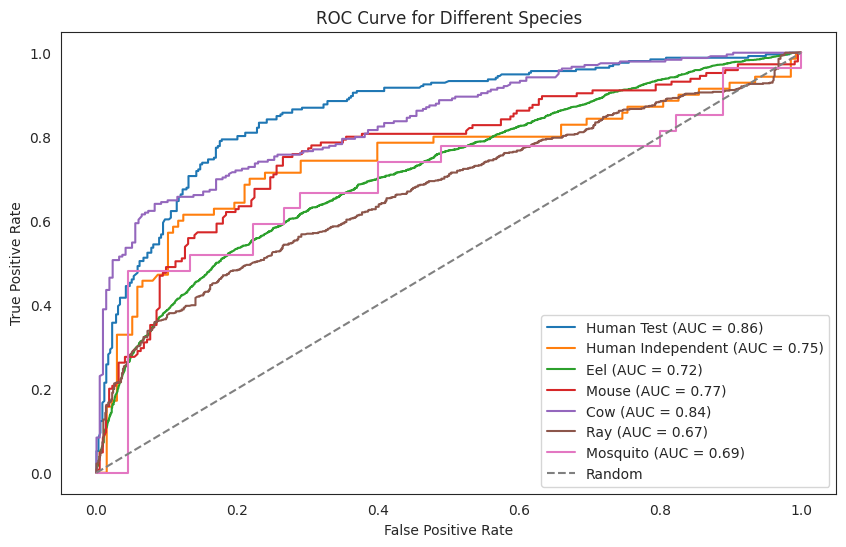

Evaluation for Human Test dataset:
Accuracy: 0.7859
Precision: 0.6984
Recall: 0.8452
F1 Score: 0.7648
MCC: 0.5804
Cohen's Kappa: 0.5716


Evaluation for Human Independent dataset:
Accuracy: 0.6058
Precision: 0.4516
Recall: 0.8000
F1 Score: 0.5773
MCC: 0.2959
Cohen's Kappa: 0.2582


Evaluation for Eel dataset:
Accuracy: 0.6248
Precision: 0.5061
Recall: 0.7155
F1 Score: 0.5928
MCC: 0.2771
Cohen's Kappa: 0.2635


Evaluation for Mouse dataset:
Accuracy: 0.5734
Precision: 0.4773
Recall: 0.8690
F1 Score: 0.6161
MCC: 0.2714
Cohen's Kappa: 0.2187


Evaluation for Cow dataset:
Accuracy: 0.7112
Precision: 0.6838
Recall: 0.8326
F1 Score: 0.7509
MCC: 0.4264
Cohen's Kappa: 0.4150


Evaluation for Ray dataset:
Accuracy: 0.5910
Precision: 0.5618
Recall: 0.7409
F1 Score: 0.6390
MCC: 0.1971
Cohen's Kappa: 0.1874


Evaluation for Mosquito dataset:
Accuracy: 0.6806
Precision: 0.5667
Recall: 0.6296
F1 Score: 0.5965
MCC: 0.3346
Cohen's Kappa: 0.3333




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score

# Set up the plot
plt.figure(figsize=(10, 6))

# Initialize a dictionary to store evaluation metrics for each dataset
evaluation_metrics = {}

# Evaluate and plot ROC curve for each dataset
for species, result in evaluation_results.items():
    y_true = datasets[species].y.ravel()
    y_pred_positive = result['model_outputs'][:, 1]

    # Calculate the ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_positive)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    # Calculate the confusion matrix
    y_pred_binary = np.argmax(result['model_outputs'], axis=1)  # Convert probabilities to binary predictions
    conf_matrix = confusion_matrix(y_true, y_pred_binary)

    # Calculate other evaluation metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    mcc = matthews_corrcoef(y_true, y_pred_binary)
    cohen_kappa = cohen_kappa_score(y_true, y_pred_binary)

    # Store the evaluation metrics in the dictionary
    evaluation_metrics[species] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'MCC': mcc,
        "Cohen's Kappa": cohen_kappa
    }

    # Plot the ROC curve for each species
    plt.plot(fpr, tpr, label=f'{species} (AUC = {roc_auc:.2f})')

    # Display Confusion Matrix
    print(f"Confusion Matrix for {species} dataset:")
    print(conf_matrix)

# Plot settings
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curve for Different Species')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Display or analyze the stored evaluation metrics
for species, metrics in evaluation_metrics.items():
    print(f"Evaluation for {species} dataset:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    print("\n")

# Create a DataFrame from the evaluation_metrics dictionary
df_metrics = pd.DataFrame(evaluation_metrics).transpose()

## Model optimization

In [ ]:
!pip install Optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 13.0 MB/s eta 0:00:00


In [ ]:
import os
import optuna
from sklearn.metrics import roc_auc_score
from simpletransformers.classification.classification_model import ClassificationModel

# Define default classification arguments
classification_args = {
    'overwrite_output_dir': True,  # Set to True to overwrite the output directory if it exists
}

# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameters to be optimized
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True)
    num_train_epochs = trial.suggest_int("num_train_epochs", 1, 10)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    warmup_steps = trial.suggest_int("warmup_steps", 0, 1000)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.3)
    adam_epsilon = trial.suggest_float("adam_epsilon", 1e-9, 1e-7, log=True)
    # Generate a unique output directory for each trial
    output_dir = f'/content/AChE_transferLearning_trial_{trial.number}'

    # Create and train the model with the given hyperparameters
    model = ClassificationModel('roberta', 'DeepChem/ChemBERTa-77M-MLM', use_cuda=True, args={**classification_args, 'learning_rate': learning_rate, 'num_train_epochs': num_train_epochs, 'train_batch_size': batch_size, 'dropout': dropout, 'warmup_steps': warmup_steps, 'weight_decay': weight_decay, 'adam_epsilon': adam_epsilon})

    model.train_model(train_df, eval_df=valid_df)  # Pass valid_df for evaluation

    # Evaluate the model and calculate ROC AUC
    eval_results = model.eval_model(valid_df)
    predictions, _ = model.predict(valid_df['X'].tolist())
    roc_auc = roc_auc_score(valid_df['y'].tolist(), predictions)

    # Return ROC AUC for optimization
    return roc_auc

# Create an Optuna study and optimize hyperparameters
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train the final model with the best hyperparameters
final_model = ClassificationModel('roberta', 'DeepChem/ChemBERTa-77M-MLM', use_cuda=True, args={**classification_args, **best_params})
final_model.train_model(train_df, eval_df=valid_df)


[I 2024-05-26 01:12:43,027] A new study created in memory with name: no-name-71f3964e-1f25-47fd-bc60-1a6ad7c59ba5
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 2:   0%|          | 0/357 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-05-26 01:13:20,371] Trial 0 finished with value: 0.6998858137132293 and parameters: {'learning_rate': 4.1994461174581736e-05, 'num_train_epochs': 2, 'batch_size': 8, 'dropout': 0.1405233248881409, 'warmup_steps': 663, 'weight_decay': 0.15598726356497164, 'adam_epsilon': 3.197912829386873e-08}. Best is trial 0 with value: 0.6998858137132293.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and i

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/90 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-05-26 01:13:37,506] Trial 1 finished with value: 0.543292915012778 and parameters: {'learning_rate': 4.1032425633617865e-05, 'num_train_epochs': 3, 'batch_size': 32, 'dropout': 0.24360823446698157, 'warmup_steps': 476, 'weight_decay': 0.09079560117430889, 'adam_epsilon': 8.147002985987295e-08}. Best is trial 0 with value: 0.6998858137132293.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and 

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 6 of 6:   0%|          | 0/357 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-05-26 01:14:32,532] Trial 2 finished with value: 0.824419553042249 and parameters: {'learning_rate': 0.00016815639328016273, 'num_train_epochs': 6, 'batch_size': 8, 'dropout': 0.43512027846378065, 'warmup_steps': 355, 'weight_decay': 0.07079889386414955, 'adam_epsilon': 6.632835189353479e-08}. Best is trial 2 with value: 0.824419553042249.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/357 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-05-26 01:14:44,664] Trial 3 finished with value: 0.7856179653091186 and parameters: {'learning_rate': 0.0006242267452857415, 'num_train_epochs': 1, 'batch_size': 8, 'dropout': 0.12457542903048058, 'warmup_steps': 126, 'weight_decay': 0.09309333214795043, 'adam_epsilon': 2.6548463217902996e-09}. Best is trial 2 with value: 0.824419553042249.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and i

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 6 of 6:   0%|          | 0/357 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-05-26 01:15:43,606] Trial 4 finished with value: 0.8357403077592301 and parameters: {'learning_rate': 0.000686825580337495, 'num_train_epochs': 6, 'batch_size': 8, 'dropout': 0.46586186427065446, 'warmup_steps': 198, 'weight_decay': 0.1196544746686692, 'adam_epsilon': 6.532084369278813e-08}. Best is trial 4 with value: 0.8357403077592301.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inf

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 8 of 8:   0%|          | 0/357 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-05-26 01:16:57,606] Trial 5 finished with value: 0.5037735849056604 and parameters: {'learning_rate': 2.618960499408798e-06, 'num_train_epochs': 8, 'batch_size': 8, 'dropout': 0.11989099592625574, 'warmup_steps': 804, 'weight_decay': 0.24721217693372294, 'adam_epsilon': 1.7037388772219368e-09}. Best is trial 4 with value: 0.8357403077592301.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and 

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 2 of 2:   0%|          | 0/90 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-05-26 01:17:07,299] Trial 6 finished with value: 0.4947039312707302 and parameters: {'learning_rate': 1.839204994007882e-06, 'num_train_epochs': 2, 'batch_size': 32, 'dropout': 0.14625738120294748, 'warmup_steps': 601, 'weight_decay': 0.13428542931867785, 'adam_epsilon': 1.5577507150922816e-08}. Best is trial 4 with value: 0.8357403077592301.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 2 of 2:   0%|          | 0/179 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-05-26 01:17:19,964] Trial 7 finished with value: 0.8136479799902127 and parameters: {'learning_rate': 0.0008684527361219844, 'num_train_epochs': 2, 'batch_size': 16, 'dropout': 0.4729417213083241, 'warmup_steps': 789, 'weight_decay': 0.0027303652706259784, 'adam_epsilon': 1.8838073436257573e-08}. Best is trial 4 with value: 0.8357403077592301.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions an

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 2:   0%|          | 0/357 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-05-26 01:17:41,696] Trial 8 finished with value: 0.5724158555815344 and parameters: {'learning_rate': 2.1532206759559394e-05, 'num_train_epochs': 2, 'batch_size': 8, 'dropout': 0.28235699634423744, 'warmup_steps': 100, 'weight_decay': 0.2897225220735843, 'adam_epsilon': 1.561483035024931e-08}. Best is trial 4 with value: 0.8357403077592301.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and i

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/357 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-05-26 01:18:31,109] Trial 9 finished with value: 0.7966287858191506 and parameters: {'learning_rate': 4.9677615054571596e-05, 'num_train_epochs': 5, 'batch_size': 8, 'dropout': 0.30584947168954835, 'warmup_steps': 24, 'weight_decay': 0.17044732232312865, 'adam_epsilon': 3.818465320647606e-09}. Best is trial 4 with value: 0.8357403077592301.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Best Hyperparameters: {'learning_rate': 0.000686825580337495, 'num_train_epochs': 6, 'batch_size': 8, 'dropout': 0.46586186427065446, 'warmup_steps': 198, 'weight_decay': 0.1196544746686692, 'adam_epsilon': 6.532084369278813e-08}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 6 of 6:   0%|          | 0/357 [00:00<?, ?it/s]

(2142, 0.4284136842824971)

In [ ]:
best_params

{'learning_rate': 0.000686825580337495,
 'num_train_epochs': 6,
 'batch_size': 8,
 'dropout': 0.46586186427065446,
 'warmup_steps': 198,
 'weight_decay': 0.1196544746686692,
 'adam_epsilon': 6.532084369278813e-08}

### Optimized model cross species evaluation

In [ ]:
import pandas as pd
import numpy as np
import sklearn

# Initialize empty lists to store results for each species
all_results = []
all_model_outputs = []
all_wrong_predictions = []

datasets = [df_humanIndependent, df_eel, df_mouse, df_cow, df_ray, df_mosquito]

species_names = ['humanIndependent', 'eel', 'mouse', 'cow', 'ray', 'mosquito']

for dataset, species_name in zip(datasets, species_names):
    # Convert NumpyDataset to Pandas DataFrame
    data_dict = {'cleanedMol': np.asarray(dataset.X), 'single-class-label': np.asarray(dataset.y)}
    current_df = pd.DataFrame(data_dict)

    # Perform evaluation
    result_test_final, model_outputs_final, wrong_predictions_final = final_model.eval_model(current_df, acc=sklearn.metrics.accuracy_score)

    # Append results for the current species to the lists
    all_results.append(pd.DataFrame({'Species': [species_name], 'Accuracy': [result_test_final]}))
    all_model_outputs.append(pd.DataFrame({'Species': [species_name], 'Model Outputs': [model_outputs_final]}))
    all_wrong_predictions.append(pd.DataFrame({'Species': [species_name], 'Wrong Predictions': [wrong_predictions_final]}))

# Concatenate all results DataFrames
results_df_final = pd.concat(all_results, ignore_index=True)

# Concatenate all model outputs DataFrames
model_outputs_df_final = pd.concat(all_model_outputs, ignore_index=True)

# Concatenate all wrong predictions DataFrames
wrong_predictions_df_final = pd.concat(all_wrong_predictions, ignore_index=True)

# Save concatenated DataFrames to a single Excel file
results_df_final.to_excel('all_results.xlsx', index=False)
model_outputs_df_final.to_excel('all_model_outputs.xlsx', index=False)
wrong_predictions_df_final.to_excel('all_wrong_predictions.xlsx', index=False)


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/10 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/55 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
import sklearn.metrics

datasets = {
    'Human Test': test_df,
    'Human Independent': df_humanIndependent,
    'Eel': df_eel,
    'Mouse': df_mouse,
    'Cow': df_cow,
    'Ray': df_ray,
    'Mosquito': df_mosquito
}

evaluation_results = {}

for dataset_name, dataset in datasets.items():
    result_final, model_outputs_final, wrong_predictions_final = final_model.eval_model(dataset, acc=sklearn.metrics.accuracy_score)
    evaluation_results[dataset_name] = {
        'result': result_final,
        'model_outputs': model_outputs_final,
        'wrong_predictions': wrong_predictions_final
    }


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/10 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/55 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
for dataset_name, result in evaluation_results.items():
    print(f"Dataset: {dataset_name}")
    print(f"Evaluation result: {result['result']}")
    print()

Dataset: Human Test
Evaluation result: {'mcc': 0.6461581587344024, 'accuracy': 0.8235294117647058, 'f1_score': 0.7985074626865671, 'tp': 214, 'tn': 290, 'fp': 70, 'fn': 38, 'auroc': 0.8862158289241624, 'auprc': 0.820191107112386, 'acc': 0.8235294117647058, 'eval_loss': 0.6416405737400055}

Dataset: Human Independent
Evaluation result: {'mcc': 0.226076048426408, 'accuracy': 0.5769230769230769, 'f1_score': 0.5416666666666666, 'tp': 52, 'tn': 68, 'fp': 70, 'fn': 18, 'auroc': 0.7508799171842649, 'auprc': 0.6927504798029887, 'acc': 0.5769230769230769, 'eval_loss': 1.0966259042421977}

Dataset: Eel
Evaluation result: {'mcc': 0.34726547186423834, 'accuracy': 0.6763143432863161, 'f1_score': 0.6182760855476345, 'tp': 1431, 'tn': 2261, 'fp': 1114, 'fn': 653, 'auroc': 0.7346722115589679, 'auprc': 0.6395069175814208, 'acc': 0.6763143432863161, 'eval_loss': 1.0026363508267837}

Dataset: Mouse
Evaluation result: {'mcc': 0.35931410172011097, 'accuracy': 0.6358695652173914, 'f1_score': 0.6510416666666

## References


*  https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Transfer_Learning_With_ChemBERTa_Transformers.ipynb
*   https://huggingface.co/DeepChem

*  Ramsundar, B., Eastman, P., Walters, P., Pande, V., Leswing, K., & Wu, Z. (2019). Deep Learning for the Life Sciences. O’Reilly Media. https://www.amazon.com/Deep-Learning-Life-Sciences-Microscopy/dp/1492039837

*  Vignaux, P. A., Lane, T. R., Urbina, F., Gerlach, J., Puhl, A. C., Snyder, S. H., & Ekins, S. (2023). Validation of Acetylcholinesterase Inhibition Machine Learning Models for Multiple Species. Chemical Research in Toxicology, 36(2), 188–201. https://doi.org/10.1021/acs.chemrestox.2c00283


*   Ahmad, W., Simon, E., Chithrananda, S., Grand, G., & Ramsundar, B. (2022). ChemBERTa-2: Towards Chemical Foundation Models (arXiv:2209.01712). arXiv. http://arxiv.org/abs/2209.01712
*   Chithrananda, S., Grand, G., & Ramsundar, B. (2020). ChemBERTa: Large-Scale Self-Supervised Pretraining for Molecular Property Prediction (Version 2). arXiv. https://doi.org/10.48550/ARXIV.2010.09885







